In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from catboost import CatBoostClassifier
import hyperopt

from sklearn.decomposition import PCA

In [2]:

df_train = pd.read_csv(r'\kaggle\input\titanic\train.csv')
df_test = pd.read_csv(r'\kaggle\input\titanic\test.csv')

## Small preprocessing

We concatenate train and test datasets for filling the gaps, creating new predictors and the rest preprocessing actions.
Majority of this ideas for create new functions I have seen on kaggle, but it's not main thought of this notebook. We will just do it quickly and move on. 

In [3]:
col = ['Pclass', 'Age', 'Fare', 'SibSp', 'Parch', 'Sex', 'Cabin', 'Ticket', 'Embarked', 'Name']

train = df_train.drop(['Survived', 'PassengerId'], axis=1)[col].copy()
target = df_train.Survived.copy()

test = df_test.drop('PassengerId', axis=1)[col].copy()

In [4]:
tr_ts = pd.concat([train, test])

In [5]:
tr_ts.shape

(1309, 10)

In [6]:
avg_age_by_cl = tr_ts.loc[tr_ts['Age'].notna()].groupby('Pclass', as_index=False).agg({'Age':'mean'})
mean_fare_by_classes = tr_ts.loc[tr_ts['Fare'].notna()].groupby('Pclass', as_index=False).agg({'Fare':'mean'})
mode_embarked_by_classes = tr_ts.loc[tr_ts['Embarked'].notna()].groupby(['Pclass', 'Embarked'], as_index=False).agg({'Age':'count'})

### Age
tr_ts.loc[(tr_ts['Age'].isnull()) & (tr_ts['Pclass'] == 1), 'Age'] = avg_age_by_cl.loc[avg_age_by_cl['Pclass'] == 1, 'Age'].values[0]
tr_ts.loc[(tr_ts['Age'].isnull()) & (tr_ts['Pclass'] == 2), 'Age'] = avg_age_by_cl.loc[avg_age_by_cl['Pclass'] == 2, 'Age'].values[0]
tr_ts.loc[(tr_ts['Age'].isnull()) & (tr_ts['Pclass'] == 3), 'Age'] = avg_age_by_cl.loc[avg_age_by_cl['Pclass'] == 3, 'Age'].values[0]

### Fare
tr_ts.Fare.fillna(tr_ts[(tr_ts.Pclass == 3) & (tr_ts.Embarked == "S") & (tr_ts.Sex == "male")].Fare.mean(), inplace=True)   

### Embarked
tr_ts.loc[(tr_ts['Embarked'].isnull()) & (tr_ts['Pclass'] == 1), 'Embarked'] = 'C'  

### Something new
tr_ts['Title'] = tr_ts['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
tr_ts['FamilySize'] = tr_ts['SibSp'] + tr_ts['Parch'] + 1
tr_ts['LastName'] = tr_ts['Name'].apply(lambda x: x.split(',')[0])
tr_ts['FamilyGroup'] = tr_ts['LastName'] + "_" + tr_ts['FamilySize'].astype(str)

#### Cabin
family_cabin_mapping = tr_ts.dropna(subset=['Cabin']).groupby('FamilyGroup')['Cabin'].agg(lambda x:x.value_counts().index[0])
tr_ts['Cabin'] = tr_ts['Cabin'].fillna('N')
tr_ts['Cabin'] = [i[0] for i in tr_ts['Cabin']]

#### Title
tr_ts['Title'] = np.select([tr_ts['Title'].isin(['Ms', 'Mlle']), 
                            tr_ts['Title'].isin(['Mme']), 
                            tr_ts['Title'].isin(['Dr', 'Col', 'Rev', 'Major', 'Don', 'Jonkheer', 
                                                 'Sir', 'Lady', 'Capt', 'Countess', 'Dona'])],
                           
                           ['Miss', 'Mrs', 'rare'], 
                           
                           tr_ts['Title'])
#### Ticket
tr_ts['Ticket_group'] = np.select([tr_ts['Ticket'].str[0] == 'A', 
                                   tr_ts['Ticket'].str[0] == 'C', 
                                   tr_ts['Ticket'].str[0] == 'F', 
                                   tr_ts['Ticket'].str[0] == 'P', 
                                   tr_ts['Ticket'].str[0] == 'S', 
                                   tr_ts['Ticket'].str[0] == 'W'], 
                                     
                                  ['A', 'C', 'F', 'P', 'S', 'W'], 
                                     
                                  'Number')
#### Ticket count

tc_for_merge = tr_ts.groupby('Ticket').agg({'Age': 'count'}).reset_index().rename(columns={'Age': 'Ticket_count'})

tr_ts = tr_ts.merge(tc_for_merge, how='left', on='Ticket')

tr_ts['Ticket_count'] = np.select([tr_ts['Ticket_count'] == 1, tr_ts['Ticket_count'] <= 4, tr_ts['Ticket_count'] > 4], 
                                  
                                  ['one', 'few', 'lot'], 
                                  
                                  'error') 

In [7]:
tr_ts = tr_ts.drop(['Name', 'LastName', 'SibSp', 'Parch', 'Ticket', 'FamilyGroup', 'Ticket_group'], axis=1)

In [8]:
tr_ts.head()

,Pclass,Age,Fare,Sex,Cabin,Embarked,Title,FamilySize,Ticket_count
0,3,22.0,7.2500,male,N,S,Mr,2,one
1,1,38.0,71.2833,female,C,C,Mrs,2,few
2,3,26.0,7.9250,female,N,S,Miss,1,one
3,1,35.0,53.1000,female,C,S,Mrs,2,few
4,3,35.0,8.0500,male,N,S,Mr,1,one


In [9]:
tr_ts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 1308
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Pclass        1309 non-null   int64  
 1   Age           1309 non-null   float64
 2   Fare          1309 non-null   float64
 3   Sex           1309 non-null   object 
 4   Cabin         1309 non-null   object 
 5   Embarked      1309 non-null   object 
 6   Title         1309 non-null   object 
 7   FamilySize    1309 non-null   int64  
 8   Ticket_count  1309 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 102.3+ KB


In [10]:
tr_ts = pd.get_dummies(tr_ts, columns=['Pclass', 'Sex', 'Embarked', 
                                       'Title', 'FamilySize', 'Ticket_count', 'Cabin'])  

In [11]:
tr_ts.head()

,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,...,Ticket_count_one,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_N,Cabin_T
0,22.0,7.2500,0,0,1,0,1,0,0,1,...,1,0,0,0,0,0,0,0,1,0
1,38.0,71.2833,1,0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2,26.0,7.9250,0,0,1,1,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
3,35.0,53.1000,1,0,0,1,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
4,35.0,8.0500,0,0,1,0,1,0,0,1,...,1,0,0,0,0,0,0,0,1,0


We standardize the values across all columns because we will further use the dimensionality reduction method for visualization of our observations. 

In [12]:
ss = StandardScaler()     

In [13]:
tr_ts.loc[:] = ss.fit_transform(tr_ts)

In [14]:
tr_ts.head(3)

,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,...,Ticket_count_one,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_N,Cabin_T
0,-0.559957,-0.503268,-0.572351,-0.518084,0.919925,-0.743497,0.743497,-0.512148,-0.32204,0.657394,...,0.914278,-0.130744,-0.228584,-0.278148,-0.190843,-0.179818,-0.127688,-0.061922,0.539377,-0.02765
1,0.659292,0.734758,1.747178,-0.518084,-1.087045,1.344995,-1.344995,1.952562,-0.32204,-1.521159,...,-1.093759,-0.130744,-0.228584,3.595210,-0.190843,-0.179818,-0.127688,-0.061922,-1.853992,-0.02765
2,-0.255145,-0.490218,-0.572351,-0.518084,0.919925,1.344995,-1.344995,-0.512148,-0.32204,0.657394,...,0.914278,-0.130744,-0.228584,-0.278148,-0.190843,-0.179818,-0.127688,-0.061922,0.539377,-0.02765


return back the division into train and test

In [15]:
train_ = tr_ts.iloc[:len(df_train)].copy()

# target

test_ = tr_ts.iloc[len(df_train):].copy()

#### Using PCA 

Now we use PCA method to possibly exclude records from the train dataset. It can increase our score if we will find real unusual observations which spoil the learning characteristics. 

Yes, when we reduce the dimension to two components, we have a small percentage of explained variance. It can be fixed by other ways creating of predictors or their new combination.

In my example I increaced my score by about 0,01 when I removed 8 observations from the train dataset. 

In [16]:
pca = PCA(n_components=2)
pca = pca.fit(train_)

In [17]:
pca.explained_variance_ratio_

array([0.14414148, 0.09668649])

In [18]:
train_pca = pd.DataFrame(pca.transform(train_)).rename(columns={0: 'x', 1: 'y'})

train_pca = pd.concat([train_pca, df_train['Survived']], axis=1)

test_pca = pd.DataFrame(pca.transform(test_)).rename(columns={0: 'x', 1: 'y'})

In [19]:
train_pca.head()

,x,y,Survived
0,-1.534768,0.125356,0
1,5.190375,-1.837232,1
2,-0.340075,1.990029,1
3,4.565094,-1.254920,1
4,-2.607184,-0.315141,0


Text(0.5, 1.0, 'Distribution after using PCA')

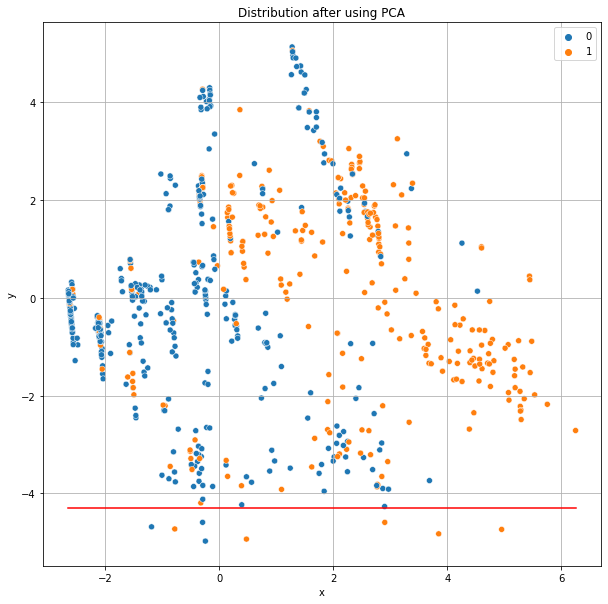

In [20]:
# 0 - died
# 1 - survived

plt.figure(figsize=(10, 10))

sns.scatterplot(data=train_pca, x='x', y='y', hue='Survived')                            # train 
# sns.scatterplot(data=test_pca, x=test_pca['x'], y=test_pca['y'], color='black')        # test 

sns.lineplot(data=train_pca, 
             x=np.linspace(train_pca['x'].min(), train_pca['x'].max(), len(train_pca)), 
             y=[-4.3 for i in range(len(train_pca))], 
             color='red')                                                               # our cut off line 

condition_1 =  (train_pca['y'] < -4.3)

#sns.scatterplot(data = train_pca, x=train_pca.loc[(condition_1) , 'x'], 
#                                  y=train_pca.loc[(condition_1) , 'y'], color='red')   # outliers

plt.grid()
plt.title('Distribution after using PCA')

Comment out one of the lines below to get a training option (train dataset) with and without outliers.

In [21]:
outliers_train_lst = list(train_pca.loc[condition_1].index); outliers_train_lst

# outliers_train_lst = []; outliers_train_lst

[96, 174, 339, 599, 630, 647, 679, 737]

In [22]:
train_ = train_.loc[~train_.index.isin(outliers_train_lst)]

target = target[~target.index.isin(outliers_train_lst)]

#### ------------------

#### Catboost model training

In [23]:
train_end = train_.copy()
test_end = test_.copy()

In [24]:
X = train_end
y = target

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=9)

In [26]:
def objective(search_space):
    
    model = CatBoostClassifier(**search_space)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)
    
    return {'loss': -model.get_best_score()['validation']['AUC'], 'status': hyperopt.STATUS_OK}
    
search_space = {
    'learning_rate': hyperopt.hp.uniform('learning_rate', 0.01, 0.2), 
    'n_estimators': hyperopt.hp.choice('n_estimators', [100, 500, 1000, 2000, 5_000]), 
    'od_type': 'Iter', 
    'od_wait': 1, 
    'l2_leaf_reg': hyperopt.hp.randint('l2_leaf_reg', 1000, 2000), 
    'depth': hyperopt.hp.randint('depth', 4, 6), 
    'bagging_temperature': hyperopt.hp.uniform('bagging_temperature', 0.01, 0.999), 
    'bootstrap_type': hyperopt.hp.choice('bootstrap_type', ['Bayesian']), 
    'boosting_type': hyperopt.hp.choice('boosting_type', ['Ordered', 'Plain']),
    'loss_function': hyperopt.hp.choice('loss_function', ['Logloss']),
    'random_strength': hyperopt.hp.uniform('random_strength', 0.001, 0.999), 
    'custom_loss': 'AUC'
               }

algoritm = hyperopt.tpe.suggest

best_params = hyperopt.fmin(fn=objective, 
                            space=search_space, 
                            algo=algoritm, 
                            max_evals=20)

hyperparams = hyperopt.space_eval(search_space, best_params)

hyperparams

100%|██████████| 20/20 [00:07<00:00,  2.65trial/s, best loss: -0.8650892857142858]


{'bagging_temperature': 0.056300542354797915,
 'boosting_type': 'Plain',
 'bootstrap_type': 'Bayesian',
 'custom_loss': 'AUC',
 'depth': 5,
 'l2_leaf_reg': 1902,
 'learning_rate': 0.185588901779335,
 'loss_function': 'Logloss',
 'n_estimators': 2000,
 'od_type': 'Iter',
 'od_wait': 1,
 'random_strength': 0.3223574048640115}

In [27]:
model = CatBoostClassifier(**hyperparams, verbose = 50)

model.fit(X_train, y_train, eval_set=(X_test, y_test), plot=False)

roc_auc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
roc_auc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

gini_train = roc_auc_train * 2 - 1
gini_test = roc_auc_test * 2 - 1

print(f'roc_auc_train - {roc_auc_train}')
print(f'gini_train - {gini_train}')
print('-'*50)
print(f'roc_auc_test - {roc_auc_test}')
print(f'gini_test - {gini_test}')
print('-'*50)
print(f'Overfitting - {gini_train - gini_test}')

0:	learn: 0.6760769	test: 0.6777310	best: 0.6777310 (0)	total: 960us	remaining: 1.92s
50:	learn: 0.4492564	test: 0.4930355	best: 0.4930355 (50)	total: 45.1ms	remaining: 1.72s
100:	learn: 0.4131766	test: 0.4675258	best: 0.4675258 (100)	total: 93.5ms	remaining: 1.76s
150:	learn: 0.3922595	test: 0.4501478	best: 0.4501478 (150)	total: 155ms	remaining: 1.9s
Stopped by overfitting detector  (1 iterations wait)

bestTest = 0.4477587187
bestIteration = 166

Shrink model to first 167 iterations.
roc_auc_train - 0.9021127389673039
gini_train - 0.8042254779346079
--------------------------------------------------
roc_auc_test - 0.8642559523809524
gini_test - 0.7285119047619049
--------------------------------------------------
Overfitting - 0.075713573172703


In [28]:
model_hard_cb = pd.concat([df_test, pd.Series(model.predict(test_), name='Survived')], axis=1); model_hard_cb

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,0


In [29]:
# our prediction

model_hard_cb[['PassengerId', 'Survived']].to_csv('submission.csv', index=False)